In [1]:
import os

In [2]:
data_dir = '/Users/Chabi/Documents/cell_images'

In [3]:
os.listdir(data_dir)

['.DS_Store', 'test', 'train']

## Custom Images - the data

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix

In [5]:
import h5py

In [6]:
test_path = data_dir + '/test/'
train_path = data_dir + '/train/'

In [7]:
os.listdir(test_path)

['.DS_Store', 'parasitized', 'uninfected']

In [8]:
os.listdir(train_path + 'parasitized')[0]

'C189P150ThinF_IMG_20151203_142224_cell_84.png'

In [9]:
para_cell = train_path + 'parasitized/' + 'C189P150ThinF_IMG_20151203_142224_cell_84.png'
imread(para_cell).shape

(121, 118, 3)

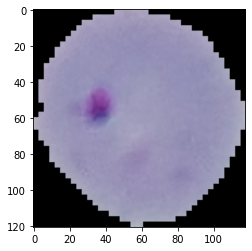

In [10]:
plt.imshow(imread(para_cell));

In [11]:
os.listdir(train_path + 'uninfected')[0]

'C13NThinF_IMG_20150614_131318_cell_179.png'

In [12]:
unifected_cell = train_path + 'uninfected/' + 'C13NThinF_IMG_20150614_131318_cell_179.png'
imread(unifected_cell).shape

(127, 115, 3)

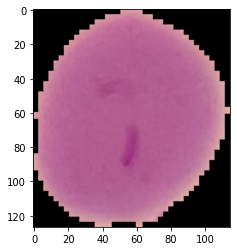

In [13]:
plt.imshow(imread(unifected_cell));

In [14]:
print(len(os.listdir(train_path + 'parasitized')))
print(len(os.listdir(train_path + 'uninfected')))

12480
12480


In [15]:
print(len(os.listdir(test_path + 'parasitized')))
print(len(os.listdir(test_path + 'uninfected')))

1300
1300


In [16]:
# different size of photos
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path + 'uninfected'):
    img = imread(test_path + 'uninfected/' + image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

/opt/anaconda3/envs/deep_learning/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


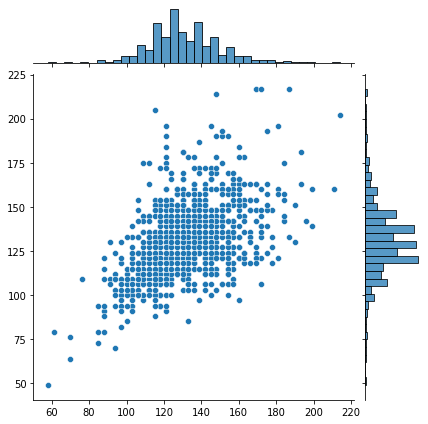

In [17]:
sns.jointplot(dim1, dim2);

In [18]:
np.mean(dim1)

130.92538461538462

In [19]:
np.mean(dim2)

130.75

In [20]:
image_shape = (130, 130, 3)

## Image data generator

In [21]:
130*130*3

50700

In [22]:
# help(ImageDataGenerator)

In [23]:
imread(para_cell).max()

0.78039217

In [24]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

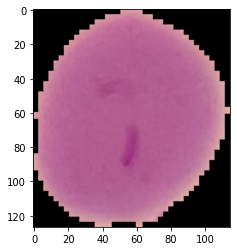

In [25]:
uni_img = imread(unifected_cell)
plt.imshow(uni_img);

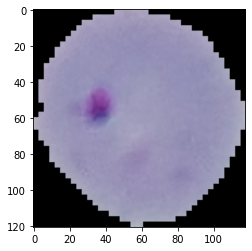

In [26]:
para_img = imread(para_cell)
plt.imshow(para_img);

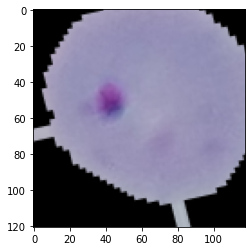

In [27]:
plt.imshow(image_gen.random_transform(para_img));

In [28]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [29]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


## Creating Model

In [30]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 input_shape=image_shape,
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 input_shape=image_shape,
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 input_shape=image_shape,
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [33]:
barch_size = 16

In [34]:
image_shape[:2]

(130, 130)

In [35]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=barch_size,
                                                class_mode='binary')

Found 24958 images belonging to 2 classes.


In [36]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=barch_size,
                                                class_mode='binary',
                                                shuffle=False)

Found 2600 images belonging to 2 classes.


In [37]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [38]:
resluts = model.fit_generator(train_image_gen,
                              epochs=20,
                              validation_data=test_image_gen,
                              callbacks=[early_stop])

In [39]:
# it's take some time so you can also load this model
model = load_model('malaria_detector.h5')

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [42]:
model.evaluate_generator(test_image_gen)

[1.8877509882205117, 0.875]

In [43]:
model.metrics_names

['loss', 'accuracy']

## Evaluating Model

In [44]:
y_pred = model.predict_generator(test_image_gen)

In [59]:
predictions = y_pred > 0.5

In [60]:
len(y_pred)

2600

In [61]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1300
           1       0.98      0.77      0.86      1300

    accuracy                           0.88      2600
   macro avg       0.89      0.88      0.87      2600
weighted avg       0.89      0.88      0.87      2600



In [62]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1279,   21],
       [ 301,  999]])

In [68]:
para_cell

'/Users/Chabi/Documents/cell_images/train/parasitized/C189P150ThinF_IMG_20151203_142224_cell_84.png'

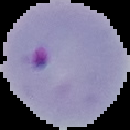

In [66]:
my_image = image.load_img(para_cell,
                          target_size=image_shape)
my_image

In [69]:
my_image_arr = image.img_to_array(my_image)

In [70]:
my_image_arr.shape

(130, 130, 3)

In [74]:
my_image_arr = np.expand_dims(my_image_arr, axis=0)

In [75]:
model.predict(my_image_arr)

array([[0.]], dtype=float32)

In [76]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}